In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


# Define the path to the folder containing images in Google Drive
folder_path = '/content/drive/MyDrive/archive (8)'

# List all files in the folder
files = os.listdir(folder_path)
print("Files in the directory:")
print(files)

Files in the directory:
['.DS_Store', 'CAT_03', 'CAT_02', 'CAT_00', 'CAT_01']


In [ ]:
# Initialize an empty list to store image paths
image_paths = []

# Recursively collect all image file paths from subfolders
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(('jpg', 'jpeg', 'png')):  # Include common image file extensions
            image_paths.append(os.path.join(root, file))

# Display the number of images found
print(f"Found {len(image_paths)} images.")

Found 5897 images.


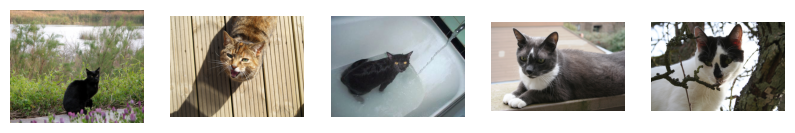

In [ ]:
# Function to display images using Matplotlib
def display_images(image_paths, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Display some of the images
display_images(image_paths)

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Create a dataset from image paths using a custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:

# Create dataset and dataloader
dataset = CustomDataset(image_paths=image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [ ]:

# Verify data loading
data_iter = iter(dataloader)
images = next(data_iter)  # Use next() function correctly
print(f"Batch shape: {images.shape}")

Batch shape: torch.Size([128, 3, 64, 64])


In [ ]:
import torch.nn as nn

# Define the Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
import torch.optim as optim

# Set random seed for reproducibility
manualSeed = 999
torch.manual_seed(manualSeed)

# Hyperparameters
nz = 100  # Size of z latent vector (i.e., size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
nc = 3    # Number of channels in the training images
num_epochs = 5
lr = 0.0002
beta1 = 0.5

In [ ]:

# Initialize generator and discriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
G_losses = []
D_losses = []

In [ ]:
print("Starting Training Loop...")

Starting Training Loop...


In [ ]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\t'
                  f'Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t'
                  f'D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

[0/5][0/47]	Loss_D: 1.4132	Loss_G: 3.4549	D(x): 0.5107	D(G(z)): 0.5094 / 0.0332
[1/5][0/47]	Loss_D: 0.2658	Loss_G: 7.9449	D(x): 0.9675	D(G(z)): 0.2047 / 0.0004
[2/5][0/47]	Loss_D: 0.6758	Loss_G: 3.8090	D(x): 0.8799	D(G(z)): 0.3967 / 0.0335
[3/5][0/47]	Loss_D: 0.3871	Loss_G: 3.9966	D(x): 0.7204	D(G(z)): 0.0144 / 0.0257
[4/5][0/47]	Loss_D: 0.6195	Loss_G: 4.2216	D(x): 0.8797	D(G(z)): 0.3239 / 0.0206


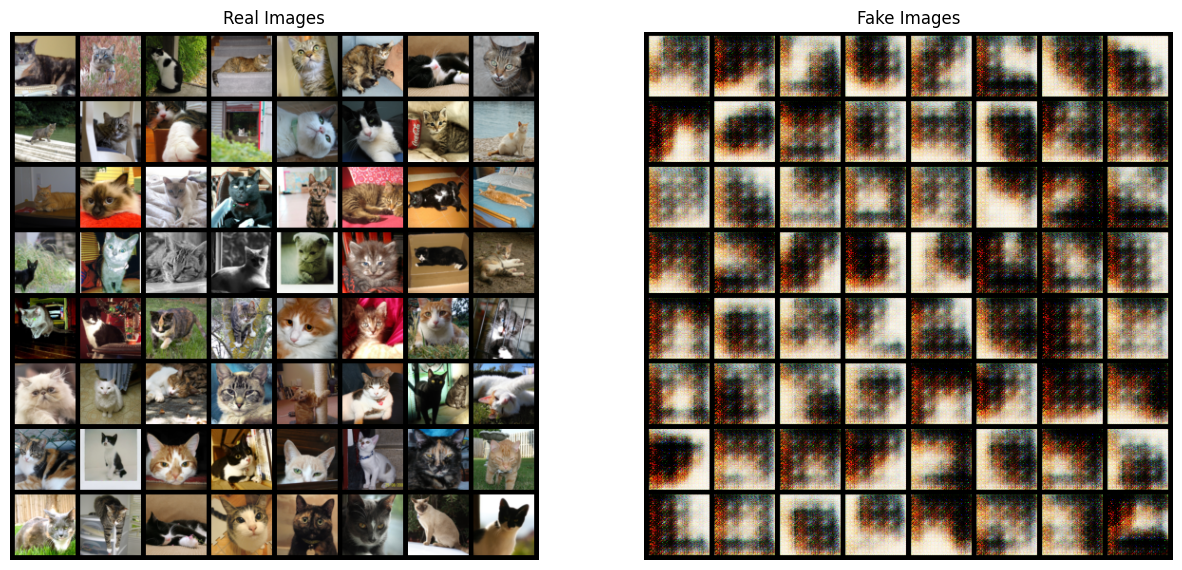

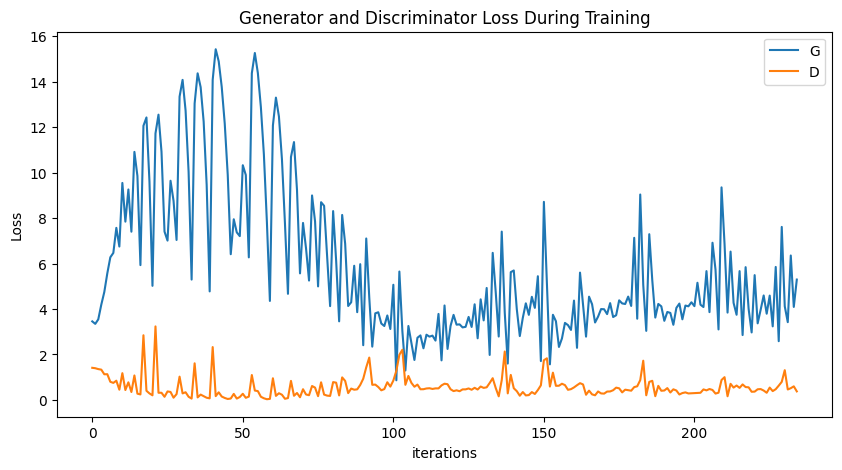

In [ ]:
import torchvision.utils as vutils

# Plot some training images
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Generate fake images with fixed noise
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fake = netG(fixed_noise).detach().cpu()

# Plot the fake images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=5, normalize=True),(1,2,0)))
plt.show()

# Plot training loss curves
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
